In [1]:
import numpy as np
import random
import copy
import statistics
import matplotlib.pyplot as plt

generation_number = list()

distance = list()
distance_min = list()
distance_max = list()
distance_mean = list()

class GA:
    # Setting=[Name, MaxGeneration, Population, EliteCount, MaxStagnationGeneration, GenesDimension ]
    def __init__(self, Setting):
        self.Name = Setting[0]
        self.MaxGeneration = Setting[1]
        self.Population = Setting[2]
        self.EliteCount = Setting[3]
        self.MaxStagnationGeneration = Setting[4]
        self.GenesDimension = Setting[5]
        print("\n GA start!! \n")

    def Start_GA(self):
        # 現在の世代
        generation = 0
        # 世代の停滞値
        Stagnation = 0
        # 目標値
        goal = 127
        # 一番適応度の良い遺伝子の軌跡
        top_genes = list()
        # 初期集団として遺伝子をランダムに作成。
        genes = self.make_genes()
        while(True):
            #　最大世代まで進むと終了
            if generation >= self.MaxGeneration:
                print(genes)
                break
            else:
                # 適応度の評価
                evaluated_data = self.evaluate(genes, goal)
                # 適応度の高い上位個体を保存
                elite_genes = copy.deepcopy(self.Save_elite(genes, evaluated_data))
                # 適応度の高い者同士を選択
                Select_id = self.select(0, genes, evaluated_data)
                # 交叉させて新しい遺伝子の作成
                genes = self.crossover(0, genes, Select_id)
                # 突然変異を与えて解探索領域を広げる
                genes = self.mutation(genes, Stagnation)
                # エリート遺伝子を加える
                genes[len(genes):len(genes)] = elite_genes
                # 一番適応度の良い個体を保存
                top_genes.append(elite_genes[0])
                # 第二世代以降において、適応度の停滞（適応度の一番良い値が更新されない）が最大停滞数を超えていればプログラムは終了。
                if len(top_genes)>=2:
                    if top_genes[-1]==top_genes[-2]:
                        # 最大停滞数を超えればアルゴリズムは終了
                        if Stagnation >= self.MaxStagnationGeneration:
                            exit()
                        else:
                            Stagnation += 1
                    else:
                        Stagnation = 0
                # 世代を進める
                generation +=1                         
                generation_number.append(generation)
                #print(genes)

    # 遺伝子をランダムに作成。一つの個体に対してself.GenesDimensionの数だけ次元を広げる
    def make_genes(self):
        genes = list()
        tmp = list()
        for child in range(self.Population):
            for _ in range(self.GenesDimension):
                tmp.append(random.randint(0,1))
            genes.append(tmp)
            tmp = list()
        # genes.shape=(self.Population, self.GenesDimension)
        #print(genes)
        return genes

    # 遺伝子の評価
    def evaluate(self, genes, goal):
        # 評価したデータは辞書型で保持。(key, value)=(child_id, fitness)
        evaluated_data = dict()
        for child in range(self.Population):
            # 適応度は高い方がよい（最大で1となるように調整。)
            fitness = round(1/(self.eval_func(genes[child], goal) + 1),2)
            evaluated_data[child] = fitness
            distance.append(self.eval_func(genes[child], goal))
        # 評価値に沿って降順ソート
        evaluated_data = dict(sorted(evaluated_data.items(),reverse=True, key=lambda x:x[1]))
        distance_min.append(int(min(distance)))
        distance_max.append(int(max(distance)))
        distance_mean.append(int(statistics.mean(distance)))
        distance.clear()
        #print(evaluated_data)
        return evaluated_data

    # evaluateの補助関数
    # 目標値との差分を計算
    def eval_func(self, gene, goal):
        a = 1
        x = 0
        for i in reversed(gene):
            x += i*a
            a *= 2
        #print(abs(goal-x))
        return (abs(goal-x))
        #sum_value = 0
        # self.GenesDimension空間における原点からのユークリッド距離を計算。
        # for id in range(len(gene)):
        #     sum_value += gene[id]**2
        # print(abs(np.sqrt(sum_value) - goal))
        # return abs(np.sqrt(sum_value) - goal)   # goal(目標値)とのずれを計算
  
    # 適応度の高い上位個体を保存
    def Save_elite(self, genes, evaluated_data):
        elite_id = list()
        elite_genes = list()
        # elite_idを辞書から取得
        for key in evaluated_data.keys():
            elite_id.append(key)
        # eliteの数だけ上から抽出
        for elite in range(self.EliteCount):
            elite_genes.append(genes[elite_id[elite]])

        return elite_genes

    def select(self, method, genes, evaluated_data):
        # idとfitnessを個別にリストで保管
        id_list = list()
        fitness_list = list()
        Select_id = list()
        for id, fitness in evaluated_data.items():
            id_list.append(id)
            fitness_list.append(fitness)

        # 期待値選択
        if method==0:
            roulette = 360
            tmp_list = list()
            sum_fitness = sum(fitness_list) # 適応度の合計値を取得
            cumulative_fitness = np.cumsum(roulette*np.array(fitness_list)/sum_fitness) # 適応度の高さに応じて幅の広い一回転360度のテーブルを作成
            for child in range(self.Population - self.EliteCount):    # エリート以外の個体を作成するため、個体数 ー エリート個体数
                for _ in range(2):                                    # ２つの遺伝子を組み合わせるため繰り返す。
                    Fate_dice = random.uniform(0,360)                 # 0~360の間の運命のサイコロを振る
                    Hit_id = 0
                    while True:
                        if cumulative_fitness[Hit_id] >= Fate_dice:
                            break
                        else:
                            #break
                            Hit_id += 1
                    tmp_list.append(id_list[Hit_id])
                Select_id.append(tmp_list)
                tmp_list = list()
        #print(Select_id)
        return Select_id

    def crossover(self, method, genes, Select_id):
        new_genes = list()
        # 次の世代のgenesをSelect_id[child][0]のid番号を使って作成
        for child in range(self.Population - self.EliteCount):
            new_genes.append(genes[Select_id[child][0]])
            #print(genes[Select_id[child][0]])
            #print(new_genes)

        if method==0:
            probability = 0.4
            for child in range(self.Population - self.EliteCount):
                for dim in range(len(genes[0])):
                    Fate_random = random.uniform(0,1)
                    if Fate_random <= probability:
                        new_genes[child][dim] = genes[Select_id[child][1]][dim]
        print(new_genes)
        return new_genes



    def mutation(self, genes, Stagnation):
        probability = 0.4                          #突然変異をする確率
        serious_rate = Stagnation/(self.MaxGeneration - self.EliteCount)   # 停滞が大きくなれば突然変異する可能性も上げる
        serious_count = int(len(genes)*serious_rate)        # genes配列の大きさを掛けることで、配列のどこまでを突然変異与えるのか調整
        for child in range(serious_count):
            for dim in range(len(genes[0])):
                Fate_random = random.uniform(0,1)      # 0~1の乱数を取得
                if Fate_random <= probability:
                    if genes[child][dim] == 0:
                        genes[child][dim] += 1
                    elif genes[child][dim] == 1:
                        genes[child][dim] -= 1
                    #genes[child][dim] += random.randint(0,1) # -10~10の乱数を付与（決め打ち）
        return genes

# Setting=[Name, MaxGeneration, Population, EliteCount, MaxStagnationGeneration, GenesDimension]
Setting = ["Sample", 15, 10, 2, 100, 10]
GA = GA(Setting)
GA.Start_GA()


 GA start!! 

[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1]]
[[0, 1, 0, 1, 0, 0, 0, 1, 0, 1], [0, 1, 0, 1, 0, 0, 0, 1, 0, 1], [0, 1, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 1, 0, 1, 0, 0, 0, 1, 0, 1], [0, 1, 0, 1, 0, 0, 0, 1, 0, 1]]
[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1]]
[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 1, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0,

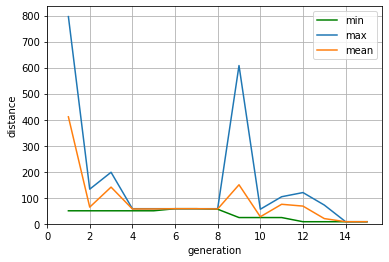

In [2]:
plt.plot(generation_number, distance_min, label="min",color="green")
plt.plot(generation_number, distance_max, label='max')
plt.plot(generation_number, distance_mean, label='mean')
plt.xlabel('generation')
plt.ylabel('distance')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.grid(True)
plt.legend()
plt.show()